## Final Project Submission

Please fill out:## PHASE II PROJECT FOR GROUP 5(Analysis of King County Housing Market)
* Student name: Prudence Coredo, Titus Mutuku, Gloria Nyongesa, Candy  Gudda, Eric Lintari, Sadi Kiri
* Student pace: Full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


**Project Overview**


- As the most populous county in Washington, King County was established in 1852 and since then, the county has experienced a significant increase in population. The increasing population drives heightened demand in the housing sector, resulting in a robust property market. Additionally, population growth exerts a significant influence on the property market by shaping economic dynamics. 
- In the thriving real estate market of King County, the recent housing boom has led to an influx of inquiries from homeowners. Local real estate agents frequently encounter questions about the impact of home renovations on house values, the significance of waterfront views, and more.  
- By analyzing King County's house sales data, we aim to assist local real estate agencies, investors, and the general population in providing meaningful answers to these homeowner inquiries. Our objective is to identify the key factors that shape house prices and quantify their influence.
- In this industry-driven endeavor, we embark on an analytical journey through King County's real estate domain where our mission is to employ advanced data science techniques to uncover the intricate factors that drive property sales and influence prices.


## Data Understanding 

- This dataset contains house sales prices for King County. It includes homes sold between May 2014 and May 2015.
- The dependent Variable: Sales Price / Selling Price
- The predictors: the sale date, renovation year, number of bedrooms and bathrooms, number of floors, the square footage of the   houses (both living and lot), and available view of waterfront. Also, the dataset contains the grade and condition of each       house.
- Datatypes: All are integers or Float except the  date and sqft_basement (object).
- Distribution of our data:
   - continuous: sqft_living, sqft_lot, sqft_above, sqft_basement (after adjustment), gap year between sold and built/renovated
   - discrete: bedrooms, bathrooms, grade, floors, condition
   - categorical: waterfront
- Our datasets contain 21,597 items of house sale information
- We will eliminate the information such as house ID, zipcode, latitude and longitude, and whether the house has been viewed or    not.

## Import the required Libraries and Load Data

In [55]:
# Import all the relevant Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
plt.style.use('seaborn')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [56]:
# Your code here - remember to use markdown cells for comments as well!
df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [25]:
top_10_highest_priced_houses = df.sort_values(by='price', ascending=False).head(10)
print(top_10_highest_priced_houses)

              id        date      price  bedrooms  bathrooms  sqft_living  \
7245  6762700020  10/13/2014  7700000.0         6       8.00        12050   
3910  9808700762   6/11/2014  7060000.0         5       4.50        10040   
9245  9208900037   9/19/2014  6890000.0         6       7.75         9890   
4407  2470100110    8/4/2014  5570000.0         5       5.75         9200   
1446  8907500070   4/13/2015  5350000.0         5       5.00         8000   
1313  7558700030   4/13/2015  5300000.0         6       6.00         7390   
1162  1247600105  10/20/2014  5110000.0         5       5.25         8010   
8085  1924059029   6/17/2014  4670000.0         5       6.75         9640   
2624  7738500731   8/15/2014  4500000.0         5       5.50         6640   
8629  3835500195   6/18/2014  4490000.0         4       3.00         6430   

      floors waterfront condition         grade sqft_basement  yr_built  \
7245     2.5         NO      Good    13 Mansion        3480.0      1910   
39

In [63]:
# List the columns you want to drop
columns_to_drop = ['sqft_lot', 'view', 'sqft_above', 'zipcode', 'sqft_living15', 'sqft_lot15']

# Use the drop() method to remove the specified columns from the "df" DataFrame
df.drop(columns=columns_to_drop, axis=1, inplace=True)


In [65]:
# Confirm the changes after droping the unnecessary columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19221 entries, 7316 to 16580
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19221 non-null  int64         
 1   date           19221 non-null  datetime64[ns]
 2   price          19221 non-null  float64       
 3   bedrooms       19221 non-null  int64         
 4   bathrooms      19221 non-null  int32         
 5   sqft_living    19221 non-null  int64         
 6   floors         19221 non-null  float64       
 7   waterfront     19221 non-null  object        
 8   condition      19221 non-null  object        
 9   grade          19221 non-null  object        
 10  sqft_basement  19221 non-null  object        
 11  yr_built       19221 non-null  int64         
 12  yr_renovated   15809 non-null  float64       
 13  lat            19221 non-null  float64       
 14  long           19221 non-null  float64       
dtypes: datetime64[ns

In [68]:
# Drop the null values in the Waterfront column
# Then convert the decimals in the bathroom to the nearest integer
df.dropna(subset=['waterfront'], inplace=True)
df['bathrooms'] = df['bathrooms'].round().astype(int)
df

,id,date,price,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,sqft_basement,yr_built,yr_renovated,lat,long
7316,2202500290,2014-05-02,435000.0,4,1,1450,1.0,NO,Good,7 Average,0.0,1954,0.0,47.5746,-122.135
17388,1868902745,2014-05-02,805000.0,3,2,2710,1.5,NO,Good,8 Good,830.0,1929,0.0,47.6747,-122.295
17024,2326059099,2014-05-02,838000.0,4,2,3310,2.0,NO,Average,9 Better,0.0,2001,NaN,47.7232,-122.131
17041,5561000920,2014-05-02,630000.0,4,3,2710,2.0,NO,Average,9 Better,0.0,2000,0.0,47.4634,-121.987
10235,3876200060,2014-05-02,382500.0,4,2,1560,1.0,NO,Good,7 Average,0.0,1967,NaN,47.7274,-122.181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7217,1786200010,2015-05-14,456500.0,4,2,2580,2.0,NO,Average,9 Better,0.0,2003,0.0,47.3658,-122.040
21434,8562790720,2015-05-14,749950.0,4,4,2630,2.0,NO,Average,10 Very Good,430.0,2008,0.0,47.5322,-122.075
5632,7923600250,2015-05-15,450000.0,5,2,1870,1.5,NO,Average,7 Average,0.0,1960,0.0,47.5951,-122.144
13040,5101400871,2015-05-24,445500.0,2,2,1390,1.0,NO,Average,6 Low Average,670.0,1941,0.0,47.6914,-122.308


In [69]:
#Confirm the changes made to the columns and the data in general   to ensure there are no nul values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19221 entries, 7316 to 16580
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19221 non-null  int64         
 1   date           19221 non-null  datetime64[ns]
 2   price          19221 non-null  float64       
 3   bedrooms       19221 non-null  int64         
 4   bathrooms      19221 non-null  int32         
 5   sqft_living    19221 non-null  int64         
 6   floors         19221 non-null  float64       
 7   waterfront     19221 non-null  object        
 8   condition      19221 non-null  object        
 9   grade          19221 non-null  object        
 10  sqft_basement  19221 non-null  object        
 11  yr_built       19221 non-null  int64         
 12  yr_renovated   15809 non-null  float64       
 13  lat            19221 non-null  float64       
 14  long           19221 non-null  float64       
dtypes: datetime64[ns

In [67]:
# Check  the dimensions (number of rows and columns) of my new DataFrame
df.shape

(19221, 15)

In [70]:
#Convert the 'date' column in the DataFrame (df) to a datetime data type and sort in ascending order
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by = 'date')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,sqft_basement,yr_built,yr_renovated,lat,long
7316,2202500290,2014-05-02,435000.0,4,1,1450,1.0,NO,Good,7 Average,0.0,1954,0.0,47.5746,-122.135
9587,472000620,2014-05-02,790000.0,3,2,2600,1.0,NO,Good,9 Better,900.0,1951,0.0,47.6833,-122.400
9578,1024069009,2014-05-02,675000.0,5,2,2820,2.0,NO,Average,8 Good,0.0,1979,0.0,47.5794,-122.025
11879,7305300695,2014-05-02,625000.0,4,2,2820,2.0,NO,Average,9 Better,0.0,2014,0.0,47.7538,-122.325
11895,3221059036,2014-05-02,400000.0,4,2,3630,1.5,NO,Average,9 Better,1330.0,1979,NaN,47.2617,-122.190


In [92]:
# Remove the  missing values in yr_renovated
df.dropna(subset=['yr_renovated'], inplace=True)
df.head()

,id,yr_sold,price,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,sqft_basement,yr_built,yr_renovated,lat,long,age_at_sale
7316,2202500290,2014-05-02,435000.0,4,1,1450,1,NO,Good,7 Average,0.0,1970-01-01 00:00:00.000001954,0.0,47.5746,-122.135,44
9587,472000620,2014-05-02,790000.0,3,2,2600,1,NO,Good,9 Better,900.0,1970-01-01 00:00:00.000001951,0.0,47.6833,-122.400,44
9578,1024069009,2014-05-02,675000.0,5,2,2820,2,NO,Average,8 Good,0.0,1970-01-01 00:00:00.000001979,0.0,47.5794,-122.025,44
11879,7305300695,2014-05-02,625000.0,4,2,2820,2,NO,Average,9 Better,0.0,1970-01-01 00:00:00.000002014,0.0,47.7538,-122.325,44
4959,7525000080,2014-05-02,588500.0,3,2,2330,1,NO,Average,8 Good,360.0,1970-01-01 00:00:00.000001980,0.0,47.6267,-122.046,44


In [75]:
# Check the possibility of having missing values
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
floors           0
waterfront       0
condition        0
grade            0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
dtype: int64

## Rename a column

In [91]:
## Rename the date column to "yr_sold"
df.rename(columns={'date': 'yr_sold'}, inplace=True)


## Create New Columns

In [90]:
# Calculating the gap year between when a house was built and when it was sold can provide valuable insights into the age of the property at the time of sale
#Gap year between yr_sold and yr_built
df['yr_sold'] = pd.to_datetime(df['yr_sold'])
df['yr_built'] = pd.to_datetime(df['yr_built'])

# Calculate the age of the property at the time of sale
df['age_at_sale'] = df['yr_sold'].dt.year - df['yr_built'].dt.year
# Convert floors to integer
df['floors'] = df['floors'].astype(int)

## Check to Confirm Liner regression Assumptions 

There are four assumptions associated with a linear regression model:

- Linearity: The relationship between X and the mean of Y is linear. (Box plots)
- Homoscedasticity: The variance of residual is the same for any value of X.(Scatter plots)
- Independence: Observations are independent of each other.
- Normality: For any fixed value of X, Y is normally distributed. （Q-Q plots）
- Before modeling, we will check the linearity and multicollinearity here.
* At the same time, we will invetigate the the relationship between our target: price and the predictors by data visualization. * We will also remove outliers from the skewed data.


## Target/Dependent variable

In [93]:
df['price'].describe()

count    1.580900e+04
mean     5.415473e+05
std      3.739273e+05
min      8.200000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.445000e+05
max      7.700000e+06
Name: price, dtype: float64

## Creating a Box Plot

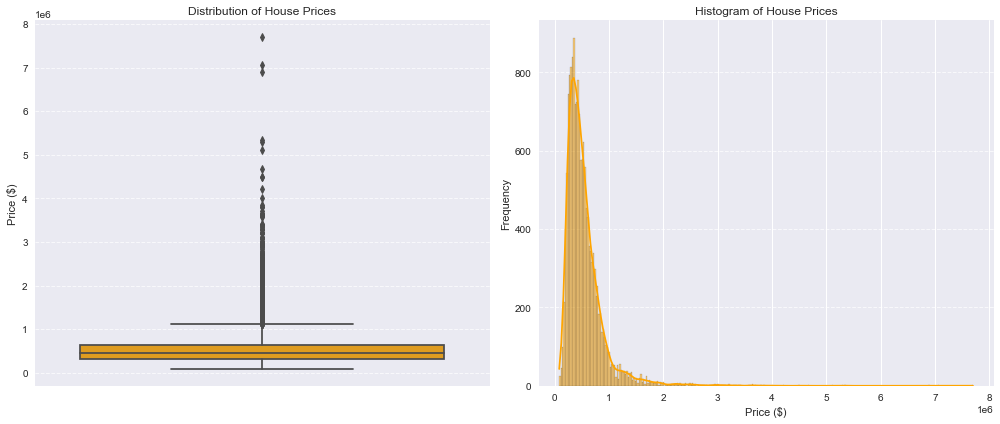

In [97]:
#Using Matplotlib and Seaborn to create a box plot and a histogram of the 'price' column from the DataFrame
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create a box plot for 'price'
sns.boxplot(data=df, y='price', ax=ax1, color='orange')  # Set the color to orange
ax1.set_ylabel('Price ($)')
ax1.set_title('Distribution of House Prices')

# Create a histogram for 'price'
sns.histplot(data=df, x='price', ax=ax2, color='orange', kde=True)  # Set the color to orange
ax2.set_xlabel('Price ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of House Prices')

# Add gridlines
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [99]:
top_10_prices = df['price'].nlargest(10)
print("Top 10 prices:")
print(top_10_prices)


Top 10 prices:
7245     7700000.0
3910     7060000.0
9245     6890000.0
1446     5350000.0
1313     5300000.0
1162     5110000.0
8085     4670000.0
2624     4500000.0
8629     4490000.0
12358    4210000.0
Name: price, dtype: float64
